<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/Weather_anomaly_detection_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dropout,Input,Conv1D,Conv1DTranspose
import matplotlib.pyplot as plot
from datetime import datetime

# Load, normalize and format data

## Load data

In [ ]:
#Load data
train_df=pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv')
test_df=pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv')


In [ ]:
print(train_df.head())

print(test_df.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


## Normalize train data

In [ ]:
#Normalize
tr_mean=train_df['value'].mean()
tr_std=train_df['value'].std()
train=(train_df['value']-tr_mean)/tr_std
print(train.head())
print(len(train))

0   -0.858829
1   -0.728993
2   -0.848148
3   -0.729586
4   -0.731173
Name: value, dtype: float64
4032


##Create sequences

In [ ]:
#format data for timeseries
def seq(data,steps):
  output=[]

  for n in range(len(data)-steps):
    output.append(data[n:n+steps])
  data=np.array(output).reshape(-1,steps,1)
  return data
steps=288
train=seq(train,steps)
print(train.shape)

(3744, 288, 1)


# Create and train model

In [ ]:
#Autoencoder

model=tf.keras.models.Sequential()
model.add(Input(shape=train.shape[-2:]))
model.add(Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"))
model.add(Conv1DTranspose(filters=1, kernel_size=7, padding="same"))
model.compile(optimizer='adam',loss='mse')
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [ ]:
#Train model
history=model.fit(train,train,epochs=50,batch_size=128,validation_split=0.1)

Epoch 1/50
27/27 [==============================] - 2s 81ms/step - loss: 0.5671 - val_loss: 0.1057
Epoch 2/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0915 - val_loss: 0.0402
Epoch 3/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0609 - val_loss: 0.0365
Epoch 4/50
27/27 [==============================] - 2s 75ms/step - loss: 0.0516 - val_loss: 0.0323
Epoch 5/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0440 - val_loss: 0.0285
Epoch 6/50
27/27 [==============================] - 2s 75ms/step - loss: 0.0384 - val_loss: 0.0271
Epoch 7/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0344 - val_loss: 0.0251
Epoch 8/50
27/27 [==============================] - 2s 75ms/step - loss: 0.0311 - val_loss: 0.0234
Epoch 9/50
27/27 [==============================] - 2s 75ms/step - loss: 0.0284 - val_loss: 0.0251
Epoch 10/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 11/

# Find anomalies

## Find max MAE loss and use this as anomaly threshold

In [ ]:


pred=model.predict(train)
loss= np.mean(np.abs(pred-train),axis=1)

threshold= np.max(loss)
print(threshold)

0.08855727058031487


## Prepare test data

In [ ]:

test=(test_df['value']-tr_mean)/tr_std
test=seq(test,steps)
print(test.shape)

(3744, 288, 1)


## Get test loss and locate anomalies

In [ ]:


te_pred=model.predict(test)
te_loss=np.mean(np.abs(te_pred - test), axis=1).reshape((-1))

In [ ]:
#Identify anomalies
anomalies=list(te_loss>threshold)
print('The number of anomalies is {} and the indices of these anomalies are{}'.format(np.sum(anomalies),np.where(anomalies)))

The number of anomalies is 400 and the indices of these anomalies are(array([ 793,  794,  795, 2522, 2523, 2701, 2702, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
       2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835,

If we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly as it is the only point in each sample.

In [ ]:
#find anomalies
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
#(i - timesteps + 1) gives the first sample i is in 
#i gives the last sample it is in
anomalies_indices=[]
for index in range (steps-1,len(test)-steps+1):
  samples=range(index-steps+1,index)
  if all([anomalies[k] for k in samples]):
    anomalies_indices.append(index)


## Plot anomalies

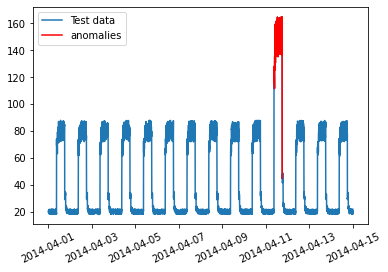

In [ ]:

anomalies_df=test_df.iloc[anomalies_indices,:]

#convert string to date time object
anom_dates=list(anomalies_df['timestamp'])
anom_dates=[datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in anom_dates]

dates=list(test_df['timestamp'])
dates=[datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in dates]


plot.figure()
plot.xticks(rotation=25)#rotate labels so no overlap
plot.plot(dates,test_df['value'],label='Test data')
plot.plot(anom_dates,anomalies_df['value'],label='anomalies',color='r')
plot.legend()